# Sequence to Sequence (Seq2Seq) Model
由于算力限制，该文件将提交至阿里云服务器运行，具体运行方法请参考阿里云文档。

部分注释使用了fitten code协助生成

# import libraries

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

seed = 42   # 设置随机种子，使得每次运行结果一致
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)


/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


sys.version_info(major=3, minor=10, micro=14, releaselevel='final', serial=0)
matplotlib 3.10.0
numpy 1.26.4
pandas 2.2.3
sklearn 1.6.1
torch 2.5.1+cu124
cuda:0


# Load Data

In [2]:
import unicodedata
import re
from sklearn.model_selection import train_test_split

#因为西班牙语有一些是特殊字符，所以我们需要unicode转ascii，
# unicode占字节数比ascii多，所以我们需要把unicode转ascii
# 这样值变小了，因为unicode太大
def unicode_to_ascii(s):
    #NFD是转换方法，把每一个字节拆开，Mn是重音，所以去除
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

#找个样本测试一下
# 加u代表对字符串进行unicode编码
en_sentence = u"May I borrow this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"

print(unicode_to_ascii(en_sentence))
print(unicode_to_ascii(sp_sentence))

May I borrow this book?
¿Puedo tomar prestado este libro?


In [3]:
def preprocess_sentence(w):
    """
    Preprocess a sentence.
    :param w:   The sentence to preprocess.
    :return:    The preprocessed sentence.
    """
    #变为小写，去掉多余的空格，变成小写，id少一些
    w = unicode_to_ascii(w.lower().strip())

    # 在单词与跟在其后的标点符号之间插入一个空格
    # eg: "he is a boy." => "he is a boy . "
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    #因为可能有多余空格，替换为一个空格，所以处理一下
    w = re.sub(r'[" "]+', " ", w)

    # 除了 (a-z, A-Z, ".", "?", "!", ",")，将所有字符替换为空格，你可以保留一些标点符号
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.rstrip().strip()

    return w

print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence))
print(preprocess_sentence(sp_sentence).encode('utf-8'))  #¿是占用两个字节的

may i borrow this book ?
¿ puedo tomar prestado este libro ?
b'\xc2\xbf puedo tomar prestado este libro ?'


# 自定义数据集


In [4]:
from pathlib import Path    #引入pathlib模块
from torch.utils.data import Dataset, DataLoader, dataset


class LangPairDataset(Dataset):
    """
    Custom dataset for language pair.
    """
    fpath = Path(r"./data_spa_en/spa.txt") #数据文件路径
    cache_path = Path(r"./.cache/lang_pair.npy") #缓存文件路径
    split_index = np.random.choice(a=["train", "test"], replace=True, p=[0.9, 0.1], size=118964) #按照9:1划分训练集和测试集
    def __init__(self, mode="train", cache=False):
        if cache or not self.cache_path.exists():#如果没有缓存，或者缓存不存在，就处理一下数据
            self.cache_path.parent.mkdir(parents=True, exist_ok=True) #创建缓存文件夹，如果存在就忽略
            with open(self.fpath, "r", encoding="utf8") as file:
                lines = file.readlines()
                lang_pair = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines] #处理数据，变成list((trg, src))的形式
                trg, src = zip(*lang_pair) #分离出目标语言和源语言
                trg=np.array(trg) #转换为numpy数组
                src=np.array(src) #转换为numpy数组
                np.save(self.cache_path, {"trg": trg, "src": src})  #保存为npy文件,方便下次直接读取,不用再处理
        else:
            lang_pair = np.load(self.cache_path, allow_pickle=True).item() #读取npy文件，allow_pickle=True允许读取字典
            trg = lang_pair["trg"]  #取出目标语言
            src = lang_pair["src"]  #取出源语言

        self.trg = trg[self.split_index == mode] #按照index拿到训练集的 标签语言 --英语
        self.src = src[self.split_index == mode] #按照index拿到训练集的源语言 --西班牙

    def __getitem__(self, index):    #返回数据
        return self.src[index], self.trg[index]

    def __len__(self):    #返回数据长度
        return len(self.src)


train_ds = LangPairDataset("train")  #训练集
test_ds = LangPairDataset("test")   #测试集

# Tokenize

In [5]:
from collections import Counter  #引入Counter模块

def get_word_idx(ds, mode="src", threshold=2):
    """
    Get word indices.
    :param ds:  The dataset.
    :param mode:    The mode of the dataset, "src" or "trg".
    :param threshold:    The threshold of word frequency.
    :return:    The word2idx and idx2word.
    """
    #载入词表，看下词表长度，词表就像英语字典
    word2idx = {
        "[PAD]": 0,     # 填充 token
        "[BOS]": 1,     # begin of sentence
        "[UNK]": 2,     # 未知 token
        "[EOS]": 3,     # end of sentence
    }
    idx2word = {value: key for key, value in word2idx.items()}  # 反向词表
    index = len(idx2word)  # 词表长度
    threshold = 1  # 出现次数低于此的token舍弃
    #如果数据集有很多个G，那是用for循环的，不能' '.join
    word_list = " ".join([pair[0 if mode=="src" else 1] for pair in ds]).split()  # 取出源语言或目标语言的单词列表
    counter = Counter(word_list) #统计词频,counter类似字典，key是单词，value是出现次数

    for token, count in counter.items():    #遍历词频
        if count >= threshold:#出现次数大于阈值的token加入词表
            word2idx[token] = index #加入词表
            idx2word[index] = token #加入反向词表
            index += 1  #词表长度加1

    return word2idx, idx2word    #返回词表和反向词表

src_word2idx, src_idx2word = get_word_idx(train_ds, "src") #源语言词表  西班牙语
trg_word2idx, trg_idx2word = get_word_idx(train_ds, "trg") #目标语言词表 英语

In [6]:
# 设置Tokenizer
class Tokenizer:
    """
    Tokenizer class.
    """
    def __init__(self, word2idx, idx2word, max_length=500, pad_idx=0, bos_idx=1, eos_idx=3, unk_idx=2):
        self.word2idx = word2idx    #词表
        self.idx2word = idx2word    #反向词表
        self.max_length = max_length    #最大长度
        self.pad_idx = pad_idx    #padding的index
        self.bos_idx = bos_idx    #bos的index
        self.eos_idx = eos_idx    #eos的index
        self.unk_idx = unk_idx    #unk的index

    def encode(self, text_list, padding_first=False, add_bos=True, add_eos=True, return_mask=False):
        """
        如果padding_first == True，则padding加载前面，否则加载后面
        return_mask: 是否返回mask(掩码），mask用于指示哪些是padding的，哪些是真实的token
        :param text_list:    The text to encode.
        :param padding_first:    Whether to padding load first.
        :param add_bos:     Whether to add bos.
        :param add_eos:     Whether to add eos.
        :param return_mask: Whether to return mask.
        :return:    The encoded text.
        """
        max_length = min(self.max_length, add_eos + add_bos + max([len(text) for text in text_list]))    #最大长度
        indices_list = []    #indices_list是一个list，里面是每个样本的index
        for text in text_list:  #遍历每个样本
            indices = [self.word2idx.get(word, self.unk_idx) for word in text[:max_length - add_bos - add_eos]] #如果词表中没有这个词，就用unk_idx代替，indices是一个list,里面是每个词的index,也就是一个样本的index
            if add_bos:  #如果需要添加bos，就在开头添加
                indices = [self.bos_idx] + indices
            if add_eos:  #如果需要添加eos，就在结尾添加
                indices = indices + [self.eos_idx]
            if padding_first:#padding加载前面，超参可以调
                indices = [self.pad_idx] * (max_length - len(indices)) + indices
            else:#padding加载后面
                indices = indices + [self.pad_idx] * (max_length - len(indices))
            indices_list.append(indices)
        input_ids = torch.tensor(indices_list) #转换为tensor
        masks = (input_ids == self.pad_idx).to(dtype=torch.int64) #mask是一个和input_ids一样大小的tensor，0代表token，1代表padding，mask用于去除padding的影响
        return input_ids if not return_mask else (input_ids, masks)


    def decode(self, indices_list, remove_bos=True, remove_eos=True, remove_pad=True, split=False):
        """
        Decode indices to text.
        :param indices_list:    The indices to decode.
        :param remove_bos:     Whether to remove bos.
        :param remove_eos:     Whether to remove eos.
        :param remove_pad:     Whether to remove pad.
        :param split:         Whether to split the text into words.
        :return:    The decoded text.
        """
        text_list = []
        for indices in indices_list:
            text = []
            for index in indices:
                word = self.idx2word.get(index, "[UNK]") #如果词表中没有这个词，就用unk_idx代替
                if remove_bos and word == "[BOS]":
                    continue
                if remove_eos and word == "[EOS]":#如果到达eos，就结束
                    break
                if remove_pad and word == "[PAD]":#如果到达pad，就结束
                    break
                text.append(word) #单词添加到列表中
            text_list.append(" ".join(text) if not split else text) #把列表中的单词拼接，变为一个句子
        return text_list

#两个相对于1个toknizer的好处是embedding的参数量减少
src_tokenizer = Tokenizer(word2idx=src_word2idx, idx2word=src_idx2word) #源语言tokenizer
trg_tokenizer = Tokenizer(word2idx=trg_word2idx, idx2word=trg_idx2word) #目标语言tokenizer

raw_text = ["hello world".split(), "tokenize text datas with batch".split(), "this is a test".split()]
indices,mask = trg_tokenizer.encode(raw_text, padding_first=False, add_bos=True, add_eos=True,return_mask=True)

# 测试一下
print("raw text"+'-'*10)
for raw in raw_text:
    print(raw)
print("mask"+'-'*10)
for m in mask:
    print(m)
print("indices"+'-'*10)
for index in indices:
    print(index)


raw text----------
['hello', 'world']
['tokenize', 'text', 'datas', 'with', 'batch']
['this', 'is', 'a', 'test']
mask----------
tensor([0, 0, 0, 0, 1, 1, 1])
tensor([0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 1])
indices----------
tensor([   1,   17, 3224,    3,    0,    0,    0])
tensor([   1,    2, 3870,    2,  538,    2,    3])
tensor([   1,  121,  233,  107, 1262,    3,    0])


In [7]:
# 测试一下decode
decode_text = trg_tokenizer.decode(indices.tolist(), remove_bos=False, remove_eos=False, remove_pad=False)
print("decode text"+'-'*10)
for decode in decode_text:
    print(decode)

decode text----------
[BOS] hello world [EOS] [PAD] [PAD] [PAD]
[BOS] [UNK] text [UNK] with [UNK] [EOS]
[BOS] this is a test [EOS] [PAD]


# DataLoader

In [8]:
def collate_fct(batch):
    """
    Collate function. 该函数用于将batch内的数据处理成统一的格式，方便后续的训练
    :param batch:    The batch to collate.
    :return:    The collated batch.
    """
    src_words = [pair[0].split() for pair in batch] #取batch内第0列进行分词，赋给src_words
    trg_words = [pair[1].split() for pair in batch] #取batch内第1列进行分词，赋给trg_words

    # [PAD] [BOS] src [EOS]
    encoder_inputs, encoder_inputs_mask = src_tokenizer.encode(
        src_words, padding_first=True, add_bos=True, add_eos=True, return_mask=True
        )   

    # [BOS] trg [PAD]
    decoder_inputs = trg_tokenizer.encode(
        trg_words, padding_first=False, add_bos=True, add_eos=False, return_mask=False,
        )

    # trg [EOS] [PAD]
    decoder_labels, decoder_labels_mask = trg_tokenizer.encode(
        trg_words, padding_first=False, add_bos=False, add_eos=True, return_mask=True
        )

    return {
        "encoder_inputs": encoder_inputs.to(device=device),
        "encoder_inputs_mask": encoder_inputs_mask.to(device=device),
        "decoder_inputs": decoder_inputs.to(device=device),
        "decoder_labels": decoder_labels.to(device=device),
        "decoder_labels_mask": decoder_labels_mask.to(device=device), #mask用于去除padding的影响，计算loss时用
    } #当返回的数据较多时，用dict返回比较合理


In [9]:
# 测试一下
sample_dl = DataLoader(train_ds, batch_size=2, shuffle=True, collate_fn=collate_fct)

#两次执行这个代码效果不一样，因为每次执行都会shuffle
for batch in sample_dl:
    for key, value in batch.items():
        print(key)
        print(value)
    break

encoder_inputs
tensor([[   0,    0,    0,    0,    1,  350, 4002, 2826, 2827,    5,    3],
        [   1,   12, 2266,  706,   80,  294,   88,   83,  297,   14,    3]],
       device='cuda:0')
encoder_inputs_mask
tensor([[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0')
decoder_inputs
tensor([[   1,  197,  756, 1413,    5,    0,    0,    0,    0,    0],
        [   1,  332,   90, 1090,  443,  158,   31,  680, 3688,   10]],
       device='cuda:0')
decoder_labels
tensor([[ 197,  756, 1413,    5,    3,    0,    0,    0,    0,    0],
        [ 332,   90, 1090,  443,  158,   31,  680, 3688,   10,    3]],
       device='cuda:0')
decoder_labels_mask
tensor([[0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0')


# Seq2Seq Model

In [10]:
class Encoder(nn.Module):
    """
    Encoder class.
    """
    def __init__(
        self,
        vocab_size, #词表大小
        embedding_dim=256,  #embedding维度
        hidden_dim=1024,    #隐藏层维度
        num_layers=1,        #层数
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)    #embedding层
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True)    #gru层

    def forward(self, encoder_inputs):  #encoder的前向传播
        # encoder_inputs.shape = [batch size, sequence length]
        # bs, seq_len = encoder_inputs.shape
        embeds = self.embedding(encoder_inputs)  #embedding层
        # embeds.shape = [batch size, sequence length, embedding_dim]->[batch size, sequence length, hidden_dim]
        seq_output, hidden = self.gru(embeds)        #gru层
        # seq_output.shape = [batch size, sequence length, hidden_dim]，hidden.shape [ num_layers, batch size, hidden_dim]
        return seq_output, hidden    #返回输出和隐藏层

In [11]:
#把上面的Encoder写一个例子，看看输出的shape
encoder = Encoder(vocab_size=100, embedding_dim=256, hidden_dim=1024, num_layers=4)
encoder_inputs = torch.randint(0, 100, (2, 50))
encoder_outputs, hidden = encoder(encoder_inputs)
print(encoder_outputs.shape)
print(hidden.shape)
print(encoder_outputs[:,-1,:])
print(hidden[-1,:,:]) #取最后一层的hidden
# 这样是为了确保数据的正确性，防止错误

torch.Size([2, 50, 1024])
torch.Size([4, 2, 1024])
tensor([[-0.0636,  0.0092,  0.0103,  ..., -0.0153, -0.0004, -0.0341],
        [-0.0175,  0.0283,  0.0105,  ...,  0.0142,  0.0282, -0.0413]],
       grad_fn=<SliceBackward0>)
tensor([[-0.0636,  0.0092,  0.0103,  ..., -0.0153, -0.0004, -0.0341],
        [-0.0175,  0.0283,  0.0105,  ...,  0.0142,  0.0282, -0.0413]],
       grad_fn=<SliceBackward0>)


# Attention Bahdanau used in the paper

In [12]:
# 注意力机制在torch中也表现为一个层，这里使用BahdanauAttention，它是一种比较常用的注意力机制，也就是加权求和的注意力机制
class BahdanauAttention(nn.Module):
    """
    BahdanauAttention class.
    """
    def __init__(self, hidden_dim=1024):
        super().__init__()
        self.Wk = nn.Linear(hidden_dim, hidden_dim) #对keys做运算，encoder的输出EO
        self.Wq = nn.Linear(hidden_dim, hidden_dim) #对query做运算，decoder的隐藏状态
        self.V = nn.Linear(hidden_dim, 1)

    def forward(self, query, keys, values, attn_mask=None):
        """
        正向传播
        :param query: hidden state，是decoder的隐藏状态，shape = [batch size, hidden_dim]
        :param keys: EO  [batch size, sequence length, hidden_dim]
        :param values: EO  [batch size, sequence length, hidden_dim]
        :param attn_mask:[batch size, sequence length],这里是encoder_inputs_mask
        :return:
        """
        # query.shape = [batch size, hidden_dim] -->通过unsqueeze(-2)增加维度 [batch size, 1, hidden_dim]
        # keys.shape = [batch size, sequence length, hidden_dim]
        # values.shape = [batch size, sequence length, hidden_dim]
        scores = self.V(F.tanh(self.Wk(keys) + self.Wq(query.unsqueeze(-2)))) #unsqueeze(-2)增加维度
        # score.shape = [batch size, sequence length, 1]
        if attn_mask is not None: #这个mask是encoder_inputs_mask，用来mask掉padding的部分,让padding部分socres为0
            # attn_mask is a matrix of 0/1 element,
            # 1 means to mask logits while 0 means do nothing
            # here we add -inf to the element while mask == 1
            attn_mask = (attn_mask.unsqueeze(-1)) * -1e16 #在最后增加一个维度，[batch size, sequence length] --> [batch size, sequence length, 1]
            scores += attn_mask
        scores = F.softmax(scores, dim=-2) #对每一个词的score做softmax
        # score.shape = [batch size, sequence length, 1]
        context_vector = torch.mul(scores, values).sum(dim=-2) #对每一个词的score和对应的value做乘法，然后在seq_len维度上求和，得到context_vector
        # context_vector.shape = [batch size, hidden_dim]
        #socres用于最后的画图
        return context_vector, scores   #返回context_vector和scores


In [13]:
# 测试一下Attention
attention = BahdanauAttention(hidden_dim=1024)
query = torch.randn(2, 1024) #Decoder的隐藏状态
keys = torch.randn(2, 50, 1024) #EO
values = torch.randn(2, 50, 1024) #EO
attn_mask = torch.randint(0, 2, (2, 50))
context_vector, scores = attention(query, keys, values, attn_mask)
print(context_vector.shape)
print(scores.shape)

torch.Size([2, 1024])
torch.Size([2, 50, 1])


In [14]:
class Decoder(nn.Module):
    """
    Decoder class.
    """
    def __init__(
        self,
        vocab_size, #词表大小
        embedding_dim=256,  #embedding维度
        hidden_dim=1024,    #隐藏层维度
        num_layers=1,        #层数
        ):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim + hidden_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size) #最后分类,词典大小是多少，就输出多少个分类
        self.dropout = nn.Dropout(0.6)
        self.attention = BahdanauAttention(hidden_dim) #注意力得到的context_vector

    def forward(self, decoder_input, hidden, encoder_outputs, attn_mask=None):
        #attn_mask是encoder_inputs_mask
        # decoder_input.shape = [batch size, 1]
        assert len(decoder_input.shape) == 2 and decoder_input.shape[-1] == 1, f"decoder_input.shape = {decoder_input.shape} is not valid"
        # hidden.shape = [batch size, hidden_dim]，decoder_hidden,而第一次使用的是encoder的hidden
        assert len(hidden.shape) == 2, f"hidden.shape = {hidden.shape} is not valid"
        # encoder_outputs.shape = [batch size, sequence length, hidden_dim]
        assert len(encoder_outputs.shape) == 3, f"encoder_outputs.shape = {encoder_outputs.shape} is not valid"
        # context_vector.shape = [batch_size, hidden_dim]
        context_vector, attention_score = self.attention(
            query=hidden, keys=encoder_outputs, values=encoder_outputs, attn_mask=attn_mask)
        # decoder_input.shape = [batch size, 1]
        embeds = self.embedding(decoder_input)
        # embeds.shape = [batch size, 1, embedding_dim]
        # context_vector.shape = [batch size, hidden_dim] -->unsqueeze(-2)增加维度 [batch size, 1, hidden_dim]
        embeds = torch.cat([context_vector.unsqueeze(-2), embeds], dim=-1)
        # 新的embeds.shape = [batch size, 1, embedding_dim + hidden_dim]
        seq_output, hidden = self.gru(embeds)
        # seq_output.shape = [batch size, 1, hidden_dim]
        logits = self.fc(self.dropout(seq_output))
        # logits.shape = [batch size, 1, vocab size]，attention_score = [batch size, sequence length, 1]
        return logits, hidden, attention_score



In [15]:
# 正式引入Seq2Seq模型
class Sequence2Sequence(nn.Module):
    """
    Sequence2Sequence class.
    """
    def __init__(
        self,
        src_vocab_size, #输入词典大小
        trg_vocab_size, #输出词典大小
        encoder_embedding_dim=256,
        encoder_hidden_dim=1024, #encoder_hidden_dim和decoder_hidden_dim必须相同，是因为BahdanauAttention设计的
        encoder_num_layers=4,    #encoder层数
        decoder_embedding_dim=256,  
        decoder_hidden_dim=1024,    
        decoder_num_layers=4,    #decoder层数
        bos_idx=1,    #开始标记
        eos_idx=3,    #结束标记
        max_length=512,  #最大长度
        ):
        super(Sequence2Sequence, self).__init__()
        self.bos_idx = bos_idx  #开始标记
        self.eos_idx = eos_idx  #结束标记
        self.max_length = max_length    #最大长度
        self.encoder = Encoder(         # encoder层数
            src_vocab_size, #输入词典大小
            embedding_dim=encoder_embedding_dim,    #embedding维度
            hidden_dim=encoder_hidden_dim,    #隐藏层维度
            num_layers=encoder_num_layers,    #层数
            )
        self.decoder = Decoder(         # decoder层数
            trg_vocab_size, #输出词典大小
            embedding_dim=decoder_embedding_dim,    #embedding维度
            hidden_dim=decoder_hidden_dim,    #隐藏层维度
            num_layers=decoder_num_layers,    #层数
            )

    def forward(self, *, encoder_inputs, decoder_inputs, attn_mask=None):
        # encoding
        encoder_outputs, hidden = self.encoder(encoder_inputs)
        # decoding with teacher forcing
        bs, seq_len = decoder_inputs.shape
        logits_list = []
        scores_list = []
        for i in range(seq_len):#串行训练
            # 每次迭代生成一个时间步的预测，存储在 logits_list 中，并且记录注意力分数（如果有的话）在 scores_list 中，最后将预测的logits和注意力分数拼接并返回。
            logits, hidden, score = self.decoder(
                decoder_inputs[:, i:i+1],
                hidden[-1], #取最后一层的hidden，第一个时间步时，hidden是encoder的hidden，第二个时间步时，hidden是decoder的hidden
                encoder_outputs,
                attn_mask=attn_mask
                )
            logits_list.append(logits) #记录预测的logits，用于计算损失
            scores_list.append(score) #记录注意力分数,用于画图

        return torch.cat(logits_list, dim=-2), torch.cat(scores_list, dim=-1)

    @torch.no_grad() #不计算梯度
    def infer(self, encoder_input, attn_mask=None):
        #infer用于预测
        # encoder_input.shape = [1, sequence length],这只支持batch_size=1
        # encoding
        encoder_outputs, hidden = self.encoder(encoder_input)

        # decoding，[[1]]
        decoder_input = torch.Tensor([self.bos_idx]).reshape(1, 1).to(dtype=torch.int64) #shape为[1,1]，内容为开始标记
        decoder_pred = None
        pred_list = [] #预测序列
        score_list = []
        # 从开始标记 bos_idx 开始，迭代地生成序列，直到生成结束标记 eos_idx 或达到最大长度 max_length。
        for _ in range(self.max_length):
            logits, hidden, score = self.decoder(
                decoder_input,
                hidden[-1],
                encoder_outputs,
                attn_mask=attn_mask
                )
            # using greedy search,logits shape = [1, 1, vocab size]
            decoder_pred = logits.argmax(dim=-1)
            decoder_input = decoder_pred
            pred_list.append(decoder_pred.reshape(-1).item()) #decoder_pred从(1,1)变为（1）标量
            score_list.append(score) #记录注意力分数,用于画图

            # stop at eos token
            if decoder_pred == self.eos_idx:
                break

        # return
        return pred_list, torch.cat(score_list, dim=-1)



In [16]:
# 测试一下Seq2Seq模型
model = Sequence2Sequence(src_vocab_size=len(src_word2idx), trg_vocab_size=len(trg_word2idx))
#做model的前向传播，看看输出的shape
encoder_inputs = torch.randint(0, 100, (2, 50))
decoder_inputs = torch.randint(0, 100, (2, 50))
attn_mask = torch.randint(0, 2, (2, 50))
logits, scores = model(encoder_inputs=encoder_inputs, decoder_inputs=decoder_inputs, attn_mask=attn_mask)
print(logits.shape)
print(scores.shape)

torch.Size([2, 50, 12469])
torch.Size([2, 50, 50])


In [17]:
#计算一下model的总参数量
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 72,968,118 trainable parameters


In [18]:
#初始化一个4层的GRU的model
model=Sequence2Sequence(src_vocab_size=len(src_word2idx), trg_vocab_size=len(trg_word2idx), encoder_num_layers=4, decoder_num_layers=4)
print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 72,968,118 trainable parameters


# 训练Seq2Seq模型
很明显由于参数过多，后面的代码放到阿里云

## 损失函数设计

In [19]:
# 采用交叉熵损失函数，并设计mask机制，使得padding部分的损失不计入损失函数的计算。
def cross_entropy_with_padding(logits, labels, padding_mask=None):
    # logits.shape = [batch size, sequence length, num of classes]
    # labels.shape = [batch size, sequence length]
    # padding_mask.shape = [batch size, sequence length] decoder_labels_mask
    bs, seq_len, nc = logits.shape
    loss = F.cross_entropy(logits.reshape(bs * seq_len, nc), labels.reshape(-1), reduce=False) #reduce=False表示不对batch求平均
    if padding_mask is None:#如果没有padding_mask，就直接求平均
        loss = loss.mean()
    else:
        # 如果提供了 padding_mask，则将padding填充部分的损失去除后计算有效损失的均值。首先，通过将 padding_mask reshape 成一维张量，并取 1 减去得到填充掩码。这样填充部分的掩码值变为 1，非填充部分变为 0。将损失张量与填充掩码相乘，这样填充部分的损失就会变为 0。然后，计算非填充部分的损失和（sum）以及非填充部分的掩码数量（sum）作为有效损失的均值计算。(因为上面我们设计的mask的token是0，所以这里是1-padding_mask)
        padding_mask = 1 - padding_mask.reshape(-1) #将padding_mask reshape成一维张量，mask部分为0，非mask部分为1
        loss = torch.mul(loss, padding_mask).sum() / padding_mask.sum()

    return loss


## callback设计

In [20]:
from torch.utils.tensorboard import SummaryWriter


class TensorBoardCallback:
    def __init__(self, log_dir, flush_secs=10):
        """
        Args:
            log_dir (str): dir to write log.
            flush_secs (int, optional): write to dsk each flush_secs seconds. Defaults to 10.
        """
        self.writer = SummaryWriter(log_dir=log_dir, flush_secs=flush_secs)

    def draw_model(self, model, input_shape):
        self.writer.add_graph(model, input_to_model=torch.randn(input_shape))

    def add_loss_scalars(self, step, loss, val_loss):
        self.writer.add_scalars(
            main_tag="training/loss",
            tag_scalar_dict={"loss": loss, "val_loss": val_loss},
            global_step=step,
            )

    def add_acc_scalars(self, step, acc, val_acc):
        self.writer.add_scalars(
            main_tag="training/accuracy",
            tag_scalar_dict={"accuracy": acc, "val_accuracy": val_acc},
            global_step=step,
        )

    def add_lr_scalars(self, step, learning_rate):
        self.writer.add_scalars(
            main_tag="training/learning_rate",
            tag_scalar_dict={"learning_rate": learning_rate},
            global_step=step,

        )

    def __call__(self, step, **kwargs):
        # add loss
        loss = kwargs.pop("loss", None)
        val_loss = kwargs.pop("val_loss", None)
        if loss is not None and val_loss is not None:
            self.add_loss_scalars(step, loss, val_loss)
        # add acc
        acc = kwargs.pop("acc", None)
        val_acc = kwargs.pop("val_acc", None)
        if acc is not None and val_acc is not None:
            self.add_acc_scalars(step, acc, val_acc)
        # add lr
        learning_rate = kwargs.pop("lr", None)
        if learning_rate is not None:
            self.add_lr_scalars(step, learning_rate)


In [21]:
# 保存最优模型
class SaveCheckpointsCallback:
    def __init__(self, save_dir, save_step=5000, save_best_only=True):
        """
        Save checkpoints each save_epoch epoch.
        We save checkpoint by epoch in this implementation.
        Usually, training scripts with pytorch evaluating model and save checkpoint by step.

        Args:
            save_dir (str): dir to save checkpoint
            save_epoch (int, optional): the frequency to save checkpoint. Defaults to 1.
            save_best_only (bool, optional): If True, only save the best model or save each model at every epoch.
        """
        self.save_dir = save_dir
        self.save_step = save_step
        self.save_best_only = save_best_only
        self.best_metrics = - np.inf

        # mkdir
        if not os.path.exists(self.save_dir):
            os.mkdir(self.save_dir)

    def __call__(self, step, state_dict, metric=None):
        if step % self.save_step > 0:
            return

        if self.save_best_only:
            assert metric is not None
            if metric >= self.best_metrics:
                # save checkpoints
                torch.save(state_dict, os.path.join(self.save_dir, "best.ckpt"))
                # update best metrics
                self.best_metrics = metric
        else:
            torch.save(state_dict, os.path.join(self.save_dir, f"{step}.ckpt"))



## 定义早停机制

In [22]:
class EarlyStopCallback:
    def __init__(self, patience=5, min_delta=0.001):
        """

        Args:
            patience (int, optional): Number of epochs with no improvement after which training will be stopped.. Defaults to 5.
            min_delta (float, optional): Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute
                change of less than min_delta, will count as no improvement. Defaults to 0.01.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_metric = - np.inf
        self.counter = 0

    def __call__(self, metric):
        if metric >= self.best_metric + self.min_delta:
            # update best metric
            self.best_metric = metric
            # reset counter
            self.counter = 0
        else:
            self.counter += 1

    @property
    def early_stop(self):
        return self.counter >= self.patience


## 训练和评估

In [23]:
# 定义训练函数
@torch.no_grad()
def evaluating(model, dataloader, loss_fct):
    loss_list = []
    for batch in dataloader:
        encoder_inputs = batch["encoder_inputs"]
        encoder_inputs_mask = batch["encoder_inputs_mask"]
        decoder_inputs = batch["decoder_inputs"]
        decoder_labels = batch["decoder_labels"]
        decoder_labels_mask = batch["decoder_labels_mask"]

        # 前向计算
        logits, _ = model(
            encoder_inputs=encoder_inputs,
            decoder_inputs=decoder_inputs,
            attn_mask=encoder_inputs_mask
            ) #model就是seq2seq模型
        loss = loss_fct(logits, decoder_labels, padding_mask=decoder_labels_mask)         # 验证集损失
        loss_list.append(loss.cpu().item())

    return np.mean(loss_list)


In [24]:
# 训练
def training(
    model,
    train_loader,
    val_loader,
    epoch,
    loss_fct,
    optimizer,
    tensorboard_callback=None,
    save_ckpt_callback=None,
    early_stop_callback=None,
    eval_step=500,
    ):
    record_dict = {
        "train": [],
        "val": []
    }

    global_step = 1
    model.train() # 切换到训练模式
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            # training
            for batch in train_loader:
                encoder_inputs = batch["encoder_inputs"]
                encoder_inputs_mask = batch["encoder_inputs_mask"]
                decoder_inputs = batch["decoder_inputs"]
                decoder_labels = batch["decoder_labels"]
                decoder_labels_mask = batch["decoder_labels_mask"]

                # 梯度清空
                optimizer.zero_grad()

                # 前向计算
                logits, _ = model(
                    encoder_inputs=encoder_inputs,
                    decoder_inputs=decoder_inputs,
                    attn_mask=encoder_inputs_mask
                    )
                loss = loss_fct(logits, decoder_labels, padding_mask=decoder_labels_mask)

                # 梯度回传
                loss.backward()

                # 调整优化器，包括学习率的变动等
                optimizer.step()

                loss = loss.cpu().item()
                # record
                record_dict["train"].append({
                    "loss": loss, "step": global_step
                })

                # evaluating
                if global_step % eval_step == 0:
                    model.eval() # 切换到验证模式
                    val_loss = evaluating(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "step": global_step
                    })
                    model.train() # 切换到训练模式

                    # 1. 使用 tensorboard 可视化
                    if tensorboard_callback is not None:
                        tensorboard_callback(
                            global_step,
                            loss=loss, val_loss=val_loss,
                            lr=optimizer.param_groups[0]["lr"],
                            )

                    # 2. 保存模型权重 save model checkpoint
                    if save_ckpt_callback is not None:
                        save_ckpt_callback(global_step, model.state_dict(), metric=-val_loss)

                    # 3. 早停 Early Stop
                    if early_stop_callback is not None:
                        early_stop_callback(-val_loss)
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict

                # udate step
                global_step += 1
                pbar.update(1)
            pbar.set_postfix({"epoch": epoch_id, "loss": loss, "val_loss": val_loss}) # 更新进度条

    return record_dict


epoch = 20
batch_size = 64

model = Sequence2Sequence(src_vocab_size=len(src_word2idx), trg_vocab_size=len(trg_word2idx))
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_fct)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fct)

# 1. 定义损失函数 采用交叉熵损失
loss_fct = cross_entropy_with_padding
# 2. 定义优化器 采用 adam
# Optimizers specified in the torch.optim package
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 1. tensorboard 可视化
if not os.path.exists("runs"):
    os.mkdir("runs")
exp_name = "translate-seq2seq"
tensorboard_callback = TensorBoardCallback(f"runs/{exp_name}")
# tensorboard_callback.draw_model(model, [1, MAX_LENGTH])
# 2. save best
if not os.path.exists("checkpoints"):
    os.makedirs("checkpoints")
save_ckpt_callback = SaveCheckpointsCallback(
    f"{exp_name}", save_step=200, save_best_only=True)
# 3. early stop
early_stop_callback = EarlyStopCallback(patience=5)

model = model.to(device)



In [25]:
# 训练模型
record = training(
    model,
    train_dl,
    test_dl,
    epoch,
    loss_fct,
    optimizer,
    tensorboard_callback=None,
    save_ckpt_callback=save_ckpt_callback,
    early_stop_callback=early_stop_callback,
    eval_step=200
    )

  0%|          | 0/33520 [00:00<?, ?it/s]/usr/local/lib/python3.10/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 47%|████▋     | 15799/33520 [28:35<32:03,  9.21it/s, epoch=8, loss=3.72, val_loss=3.69]  

Early stop at epoch 9 / global_step 15800


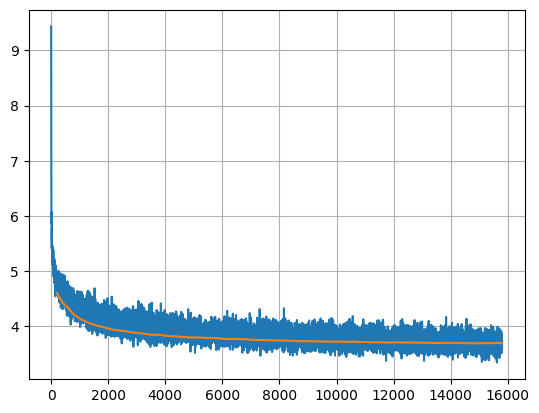

In [26]:
# 画图
import matplotlib.pyplot as plt
plt.plot([i["step"] for i in record["train"]], [i["loss"] for i in record["train"]], label="train")
plt.plot([i["step"] for i in record["val"]], [i["loss"] for i in record["val"]], label="val")
plt.grid()
plt.show()

# 推理和预测

In [27]:
# load checkpoints,如何上线
model = Sequence2Sequence(src_vocab_size=len(src_word2idx), trg_vocab_size=len(trg_word2idx), encoder_num_layers=4, decoder_num_layers=4)
model.load_state_dict(torch.load(f"./translate-seq2seq/best.ckpt", weights_only=True,map_location="cpu"))

class Translator:
    def __init__(self, model, src_tokenizer, trg_tokenizer):
        self.model = model
        self.model.eval() # 切换到验证模式
        self.src_tokenizer = src_tokenizer
        self.trg_tokenizer = trg_tokenizer

    def draw_attention_map(self, scores, src_words_list, trg_words_list):
        """绘制注意力热力图

        Args:
            - scores (numpy.ndarray): shape = [source sequence length, target sequence length]
        """
        plt.matshow(scores.T, cmap='viridis') # 注意力矩阵,显示注意力分数值
        # 获取当前的轴
        ax = plt.gca()

        # 设置热图中每个单元格的分数的文本
        for i in range(scores.shape[0]): #输入
            for j in range(scores.shape[1]): #输出
                ax.text(j, i, f'{scores[i, j]:.2f}',  # 格式化数字显示
                               ha='center', va='center', color='k')

        plt.xticks(range(scores.shape[0]), src_words_list)
        plt.yticks(range(scores.shape[1]), trg_words_list)
        plt.show()

    def __call__(self, sentence):
        sentence = preprocess_sentence(sentence) # 预处理句子，标点符号处理等
        encoder_input, attn_mask = self.src_tokenizer.encode(
            [sentence.split()],
            padding_first=True,
            add_bos=True,
            add_eos=True,
            return_mask=True,
            ) # 对输入进行编码，并返回encode_piadding_mask
        encoder_input = torch.Tensor(encoder_input).to(dtype=torch.int64) # 转换成tensor

        preds, scores = model.infer(encoder_input=encoder_input, attn_mask=attn_mask) #预测

        trg_sentence = self.trg_tokenizer.decode([preds], split=True, remove_eos=False)[0] #通过tokenizer转换成文字

        src_decoded = self.src_tokenizer.decode(
            encoder_input.tolist(),
            split=True,
            remove_bos=False,
            remove_eos=False
            )[0] #对输入编码id进行解码，转换成文字,为了画图

        self.draw_attention_map(
            scores.squeeze(0).numpy(),
            src_decoded, # 注意力图的源句子
            trg_sentence # 注意力图的目标句子
            )
        return " ".join(trg_sentence[:-1])




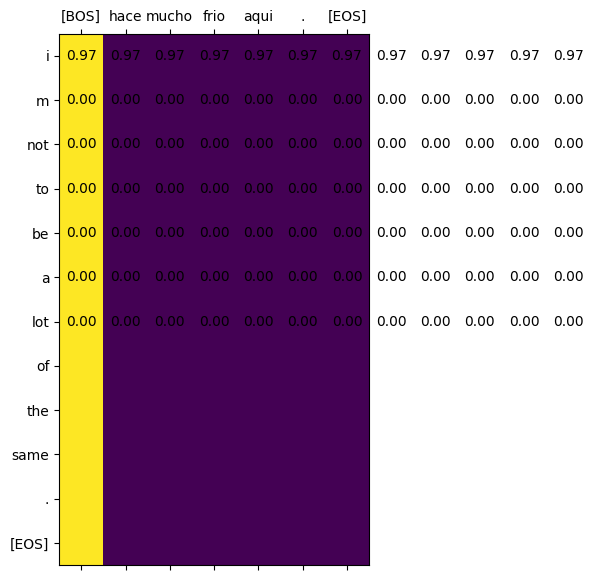

'i m not to be a lot of the same .'

In [28]:
# 实例化翻译器
translator = Translator(model.cpu(), src_tokenizer, trg_tokenizer)
translator(u'hace mucho frio aqui .')

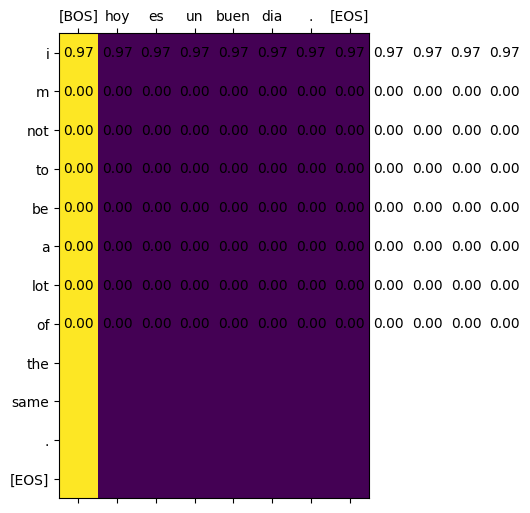

'i m not to be a lot of the same .'

In [29]:
# 使用几个例子测试
translator(u'Hoy es un buen día.')

In [ ]:
# 计算 BLEU 分数
model = Sequence2Sequence(src_vocab_size=len(src_word2idx), trg_vocab_size=len(trg_word2idx), encoder_num_layers=4, decoder_num_layers=4)
model.load_state_dict(torch.load(f"./translate-seq2seq/best.ckpt", map_location="cpu"))

class Translator:
    def __init__(self, model, src_tokenizer, trg_tokenizer):
        self.model = model
        self.model.eval() # 切换到验证模式
        self.src_tokenizer = src_tokenizer
        self.trg_tokenizer = trg_tokenizer

    def __call__(self, sentence):
        sentence = preprocess_sentence(sentence) # 预处理句子，标点符号处理等
        encoder_input, attn_mask = self.src_tokenizer.encode(
            [sentence.split()],
            padding_first=True,
            add_bos=True,
            add_eos=True,
            return_mask=True,
            ) # 对输入进行编码，并返回encode_piadding_mask
        encoder_input = torch.Tensor(encoder_input).to(dtype=torch.int64) # 转换成tensor

        preds, scores = model.infer(encoder_input=encoder_input, attn_mask=attn_mask) #预测

        trg_sentence = self.trg_tokenizer.decode([preds], split=True, remove_eos=False)[0] #通过tokenizer转换成文字

        return " ".join(trg_sentence[:-1])

from nltk.translate.bleu_score import sentence_bleu

def evaluate_bleu_on_test_set(test_data, translator):
    """
    在测试集上计算平均 BLEU 分数。
    :param test_data: 测试集数据，格式为 [(src_sentence, [ref_translation1, ref_translation2, ...]), ...]
    :param translator: 翻译器对象（Translator 类的实例）
    :return: 平均 BLEU 分数
    """
    total_bleu = 0.0
    num_samples = len(test_data)
    i=0
    for src_sentence, ref_translations in test_data:
        # 使用翻译器生成翻译结果
        candidate_translation = translator(src_sentence)

        # 计算 BLEU 分数
        bleu_score = sentence_bleu([ref_translations.split()], candidate_translation.split(),weights=(1, 0, 0, 0))
        total_bleu += bleu_score

        # 打印当前句子的 BLEU 分数（可选）
        # print(f"Source: {src_sentence}")
        # print(f"Reference: {ref_translations}")
        # print(f"Candidate: {candidate_translation}")
        # print(f"BLEU: {bleu_score:.4f}")
        # print("-" * 50)
        # i+=1
        # if i>10:
        #     break
    # 计算平均 BLEU 分数
    avg_bleu = total_bleu / num_samples
    return avg_bleu
translator = Translator(model.cpu(), src_tokenizer, trg_tokenizer)
evaluate_bleu_on_test_set(test_ds, translator)